In [1]:
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

import numpy as np
import matplotlib.pyplot as plt

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="CMAES_2qb")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 103kB
Dimensions:  (dim_0: 680)
Coordinates:
    x0       (dim_0) float64 5kB 7.378e+09 7.38e+09 ... 7.389e+09 7.388e+09
    x1       (dim_0) float64 5kB 0.03061 0.01235 0.02587 ... 0.02061 0.02206
    x2       (dim_0) float64 5kB 1.92e-07 3.56e-07 5e-07 ... 6.32e-07 5.88e-07
    x3       (dim_0) float64 5kB 7.297e+09 7.287e+09 ... 7.298e+09 7.298e+09
    x4       (dim_0) float64 5kB 0.00578 0.01308 0.02431 ... 0.03757 0.03601
    x5       (dim_0) float64 5kB 1.6e-07 6.4e-08 7.2e-08 ... 5.04e-07 4.52e-07
Dimensions without coordinates: dim_0
Data variables: (12/13)
    y0       (dim_0) float64 5kB -3.822 -3.673 -8.037 ... -14.54 -14.0 -14.3
    y1       (dim_0) float64 5kB 0.6971 0.76 0.9664 ... 0.9761 0.9788 0.9839
    y2       (dim_0) float64 5kB 0.621 0.6168 0.9869 ... 0.99 0.9859 0.992
    y3       (dim_0) float64 5kB 0.7659 0.8374 0.996 ... 0.9869 0.998 0.998
    y4       (dim_0) float64 5kB 0.7044 0.8259 0.9164 ... 0.9515 0.9526 0.9618
    y5       (dim_0) float64 5kB 0.5 0.5531 0.9377 ... 0.9603 0.9589 0.9672
    ...       ...
    y7       (dim_0) float64 5kB 0.6532 0.5642 0.7097 ... 0.9852 0.983 0.9818
    y8       (dim_0) float64 5kB 0.5978 0.5786 0.5819 ... 0.9939 0.9898 0.9868
    y9       (dim_0) float64 5kB 0.6747 0.551 0.7825 ... 0.9909 0.9939 0.9899
    y10      (dim_0) float64 5kB 0.6872 0.5628 0.7648 ... 0.9706 0.9654 0.9687
    y11      (dim_0) float64 5kB 0.5365 0.5257 0.5149 ... 0.9647 0.9604 0.9323
    y12      (dim_0) float64 5kB 0.5582 0.5 0.5148 0.5 ... 0.9432 0.9445 0.9477
Attributes:
    tuid:                             20250124-114229-836-ebf547
    name:                             CMAES
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True

In [4]:
def process_fidelity_data(dataset, popsize, n_qubits):
    """
    Processes fidelity data for n qubits based on the given dataset and population size.

    Parameters:
        dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
        popsize: The size of the population.
        n_qubits: The number of qubits.

    Returns:
        A dictionary containing mean and population fidelity data for all qubits and shared parameters.
    """
    # Extract parameters shared across all qubits
    shared_data = {
        'freq': dataset.x0.data,
        'ampl': dataset.x1.data,
        'dur': dataset.x2.data,
        'objective': dataset.y0.data,
    }

    # Initialize dictionary to hold data for each qubit
    fidelity_data = {'shared': shared_data}

    for q in range(1, n_qubits + 1):
        # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
        start_idx = 1 + (q - 1) * 6
        # Extract fidelity data for the current qubit
        fidelity_data[f'q{q}'] = {
            'assfid_av': getattr(dataset, f'y{start_idx}').data,
            'assfid_01': getattr(dataset, f'y{start_idx + 1}').data,
            'assfid_02': getattr(dataset, f'y{start_idx + 2}').data,
            'assfid_12': getattr(dataset, f'y{start_idx + 3}').data,
            'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
            'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
        }

        # Calculate mean fidelity values
        fidelity_data[f'q{q}']['mean'] = {
            key: fidelity_data[f'q{q}'][key][popsize::popsize + 1]
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }

        # print(fidelity_data[f'q{q}']['assfid_av'][0::popsize+1])
        # Calculate population fidelity values using the new slicing logic
        fidelity_data[f'q{q}']['pop'] = {
            key: np.array([
                fidelity_data[f'q{q}'][key][i::popsize+1]
                for i in range(popsize)
            ])
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }


    return fidelity_data

In [5]:
fidelity_results_2qb = process_fidelity_data(dataset, 16, 2)

In [6]:
# Access results for a specific qubit
qubit1_mean = fidelity_results_2qb['q1']['mean']['qndpifid'] 
qubit1_pop = fidelity_results_2qb['q1']['pop']['qndpifid']

qubit2_mean = fidelity_results_2qb['q2']['mean']['qndpifid'] 
qubit2_pop = fidelity_results_2qb['q2']['pop']['qndpifid']

# qubit1_mean_12 = fidelity_results_2qb['q2']['mean']['assfid_12'] 
# qubit1_pop_12 = fidelity_results_2qb['q2']['pop']['assfid_12']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
for i in range(popsize):
    plt.plot(range(Ngen),qubit2_pop[i],".",c="red",alpha=.1)

# plt.plot(range(Ngen),qubit1_mean_12,'-o',c="green",ms=3, label = "12")
# for i in range(popsize):
#     plt.plot(range(Ngen),qubit1_pop_12[i],".",c="green",alpha=.1)

# plt.title("X3")
plt.ylim(0.5,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

NameError: name 'Ngen' is not defined

In [4]:
Ngen = 40
popsize = 16

freq_q1 = dataset.x0.data
ampl_q1 = dataset.x1.data
dur_q1 = dataset.x2.data

freq_q2 = dataset.x3.data
ampl_q2 = dataset.x4.data
dur_q2 = dataset.x5.data

objective = dataset.y0.data

assfid_av_q1 = dataset.y1.data
assfid_01_q1 = dataset.y2.data
assfid_02_q1 = dataset.y3.data
assfid_12_q1 = dataset.y4.data
qndfid_q1 = dataset.y5.data
qndpifid_q1 = dataset.y6.data

assfid_av_q2 = dataset.y7.data
assfid_01_q2 = dataset.y8.data
assfid_02_q2 = dataset.y9.data
assfid_12_q2 = dataset.y10.data
qndfid_q2 = dataset.y11.data
qndpifid_q2 = dataset.y12.data

#Qubit 1 fidelity of the mean
mean_assfid_av_q1 = assfid_av_q1[popsize::popsize+1]
mean_assfid_01_q1 = assfid_01_q1[popsize::popsize+1]
mean_assfid_02_q1 = assfid_02_q1[popsize::popsize+1]
mean_assfid_12_q1 = assfid_12_q1[popsize::popsize+1]
mean_qndfid_q1 = qndfid_q1[popsize::popsize+1]
mean_qndpifid_q1 = qndpifid_q1[popsize::popsize+1]

#Qubit 2 fidelity of the mean
mean_assfid_av_q2 = assfid_av_q2[popsize::popsize+1]
mean_assfid_01_q2 = assfid_01_q2[popsize::popsize+1]
mean_assfid_02_q2 = assfid_02_q2[popsize::popsize+1]
mean_assfid_12_q2 = assfid_12_q2[popsize::popsize+1]
mean_qndfid_q2 = qndfid_q2[popsize::popsize+1]
mean_qndpifid_q2 = qndpifid_q2[popsize::popsize+1]


mask = (np.arange(1, len(assfid_av_q1) + 1) % int(popsize+1) != 0)

#Qubit 1 fidelity of the population
pop_assfid_av_q1 = assfid_av_q1[mask].reshape(popsize,-1)
pop_assfid_01_q1 = assfid_01_q1[mask].reshape(popsize,-1)
pop_assfid_02_q1 = assfid_02_q1[mask].reshape(popsize,-1)
pop_assfid_12_q1 = assfid_12_q1[mask].reshape(popsize,-1)
pop_qndfid_q1 = qndfid_q1[mask].reshape(popsize,-1)
pop_qndpifid_q1 = qndpifid_q1[mask].reshape(popsize,-1)

#Qubit 2 fidelity of the population 
pop_assfid_av_q2 = assfid_av_q2[mask].reshape(popsize,-1)
pop_assfid_01_q2 = assfid_01_q2[mask].reshape(popsize,-1)
pop_assfid_02_q2 = assfid_02_q2[mask].reshape(popsize,-1)
pop_assfid_12_q2 = assfid_12_q2[mask].reshape(popsize,-1)
pop_qndfid_q2 = qndfid_q2[mask].reshape(popsize,-1)
pop_qndpifid_q2 = qndpifid_q2[mask].reshape(popsize,-1)

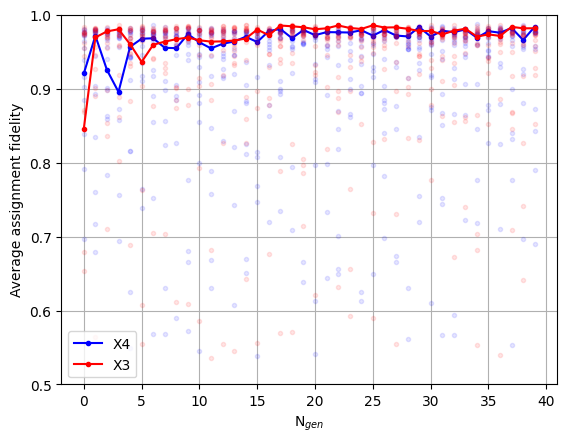

In [5]:
plt.plot(range(Ngen),mean_assfid_av_q1,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),pop_assfid_av_q1[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),mean_assfid_av_q2,'-o',c="red",ms=3, label = "X3")
for i in range(popsize):
    plt.plot(range(Ngen),pop_assfid_av_q2[i],".",c="red",alpha=.1)
    
plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

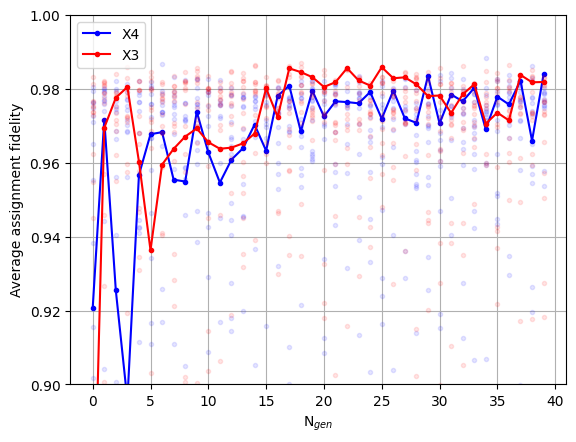

In [6]:
plt.plot(range(Ngen),mean_assfid_av_q1,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),pop_assfid_av_q1[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),mean_assfid_av_q2,'-o',c="red",ms=3, label="X3")
for i in range(popsize):
    plt.plot(range(Ngen),pop_assfid_av_q2[i],".",c="red",alpha=.1)
    
plt.ylim(0.9,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

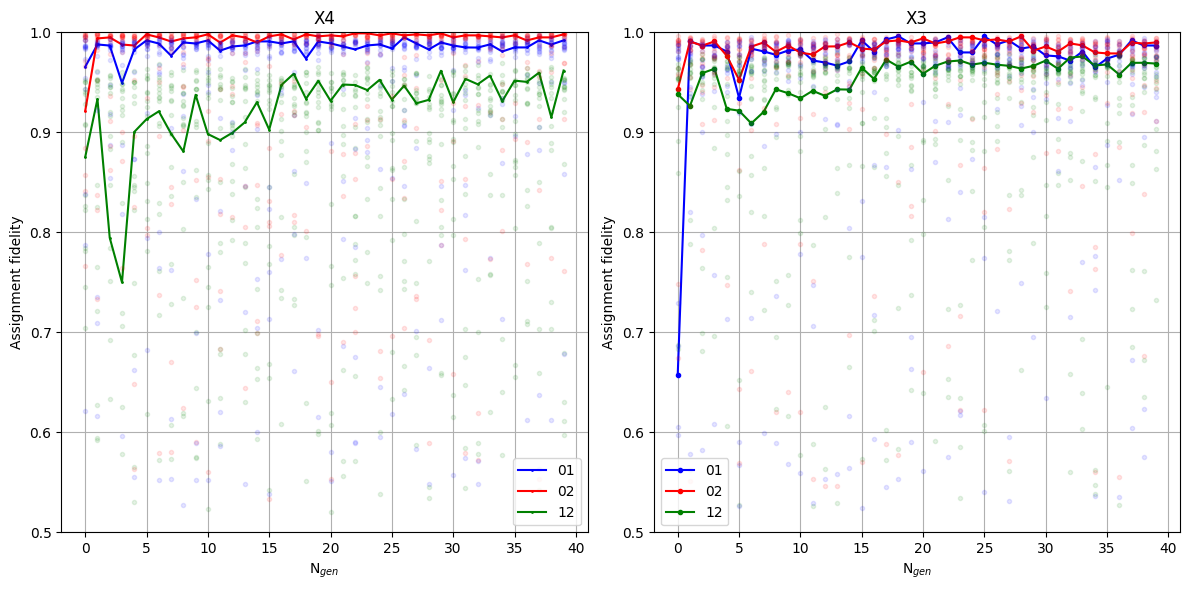

In [7]:
# Create the subplot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for q1 (left plot)
axes[0].plot(range(Ngen), mean_assfid_01_q1, '-o', c="blue", ms=1, label="01")
axes[0].plot(range(Ngen), mean_assfid_02_q1, '-o', c="red", ms=1, label="02")
axes[0].plot(range(Ngen), mean_assfid_12_q1, '-o', c="green", ms=1, label="12")

for i in range(popsize):
    axes[0].plot(range(Ngen), pop_assfid_01_q1[i], ".", c="blue", alpha=.1)
    axes[0].plot(range(Ngen), pop_assfid_02_q1[i], ".", c="red", alpha=.1)
    axes[0].plot(range(Ngen), pop_assfid_12_q1[i], ".", c="green", alpha=.1)

axes[0].set_title("X4")
axes[0].set_ylim(0.5, 1)
axes[0].set_ylabel("Assignment fidelity")
axes[0].set_xlabel(r"N$_{gen}$")
axes[0].grid()
axes[0].legend()

# Plot for q2 (right plot)
axes[1].plot(range(Ngen), mean_assfid_01_q2, '-o', c="blue", ms=3, label="01")
axes[1].plot(range(Ngen), mean_assfid_02_q2, '-o', c="red", ms=3, label="02")
axes[1].plot(range(Ngen), mean_assfid_12_q2, '-o', c="green", ms=3, label="12")

for i in range(popsize):
    axes[1].plot(range(Ngen), pop_assfid_01_q2[i], ".", c="blue", alpha=.1)
    axes[1].plot(range(Ngen), pop_assfid_02_q2[i], ".", c="red", alpha=.1)
    axes[1].plot(range(Ngen), pop_assfid_12_q2[i], ".", c="green", alpha=.1)

axes[1].set_title("X3")
axes[1].set_ylim(0.5, 1)
axes[1].set_ylabel("Assignment fidelity")
axes[1].set_xlabel(r"N$_{gen}$")
axes[1].grid()
axes[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


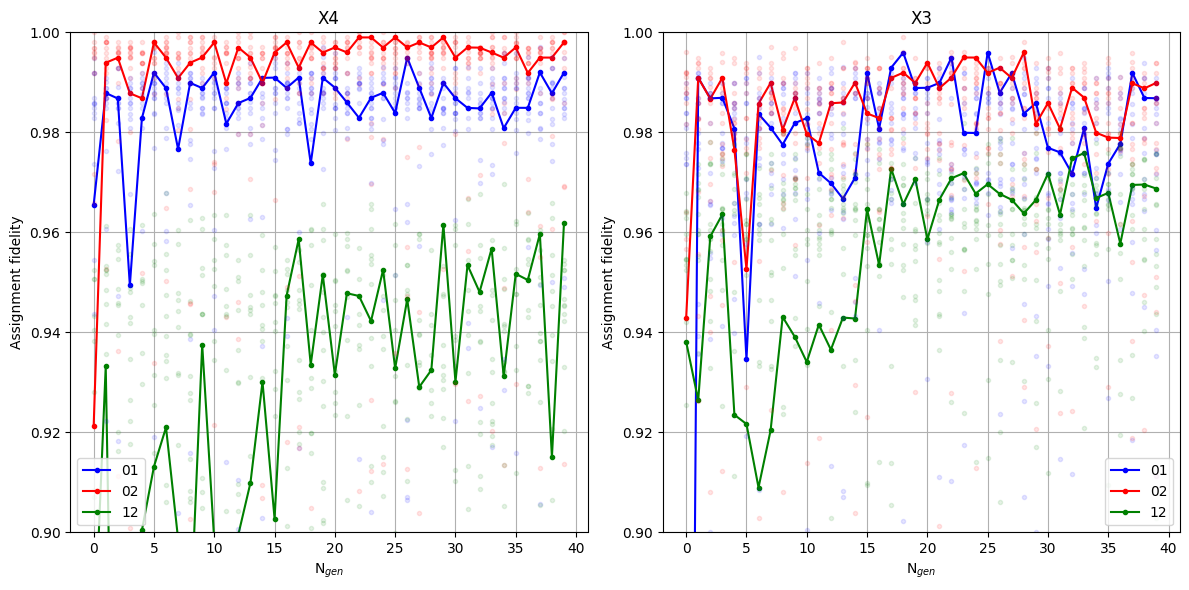

In [8]:
# Create the subplot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for q1 (left plot)
axes[0].plot(range(Ngen), mean_assfid_01_q1, '-o', c="blue", ms=3, label="01")
axes[0].plot(range(Ngen), mean_assfid_02_q1, '-o', c="red", ms=3, label="02")
axes[0].plot(range(Ngen), mean_assfid_12_q1, '-o', c="green", ms=3, label="12")

for i in range(popsize):
    axes[0].plot(range(Ngen), pop_assfid_01_q1[i], ".", c="blue", alpha=.1)
    axes[0].plot(range(Ngen), pop_assfid_02_q1[i], ".", c="red", alpha=.1)
    axes[0].plot(range(Ngen), pop_assfid_12_q1[i], ".", c="green", alpha=.1)

axes[0].set_title("X4")
axes[0].set_ylim(0.9, 1)
axes[0].set_ylabel("Assignment fidelity")
axes[0].set_xlabel(r"N$_{gen}$")
axes[0].grid()
axes[0].legend()

# Plot for q2 (right plot)
axes[1].plot(range(Ngen), mean_assfid_01_q2, '-o', c="blue", ms=3, label="01")
axes[1].plot(range(Ngen), mean_assfid_02_q2, '-o', c="red", ms=3, label="02")
axes[1].plot(range(Ngen), mean_assfid_12_q2, '-o', c="green", ms=3, label="12")

for i in range(popsize):
    axes[1].plot(range(Ngen), pop_assfid_01_q2[i], ".", c="blue", alpha=.1)
    axes[1].plot(range(Ngen), pop_assfid_02_q2[i], ".", c="red", alpha=.1)
    axes[1].plot(range(Ngen), pop_assfid_12_q2[i], ".", c="green", alpha=.1)

axes[1].set_title("X3")
axes[1].set_ylim(0.9, 1)
axes[1].set_ylabel("Assignment fidelity")
axes[1].set_xlabel(r"N$_{gen}$")
axes[1].grid()
axes[1].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


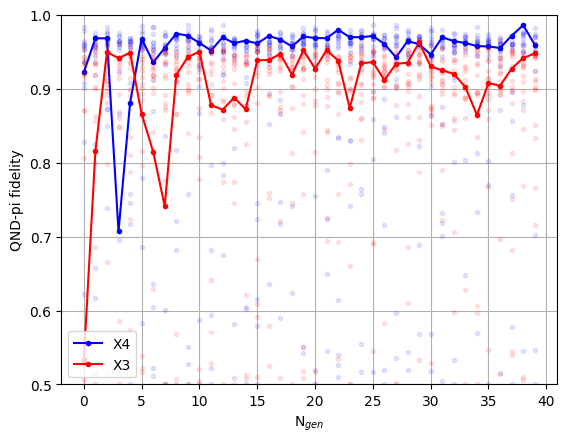

In [11]:
plt.plot(range(Ngen),mean_qndpifid_q1,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),pop_qndpifid_q1[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),mean_qndpifid_q2,'-o',c="red",ms=3, label="X3")
for i in range(popsize):
    plt.plot(range(Ngen),pop_qndpifid_q2[i],".",c="red",alpha=.1)
    
plt.ylim(0.5,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

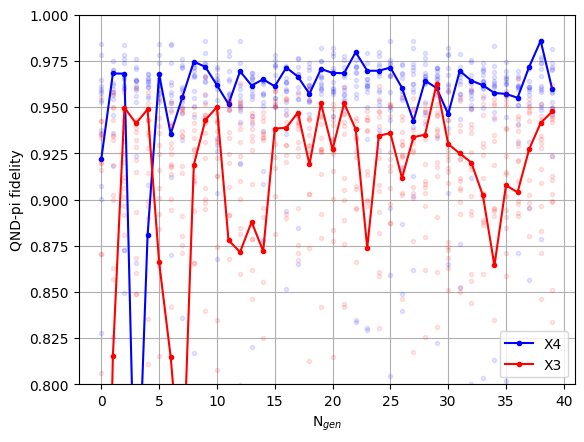

In [10]:
plt.plot(range(Ngen),mean_qndpifid_q1,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),pop_qndpifid_q1[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),mean_qndpifid_q2,'-o',c="red",ms=3, label="X3")
for i in range(popsize):
    plt.plot(range(Ngen),pop_qndpifid_q2[i],".",c="red",alpha=.1)
    
plt.ylim(0.8,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

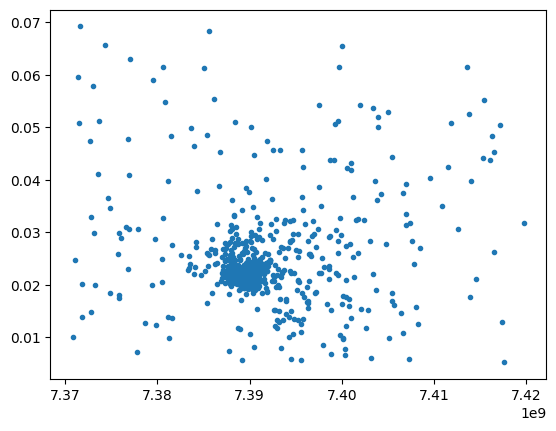

In [104]:
plt.plot(freq_q1,ampl_q1, "." )
plt.show()

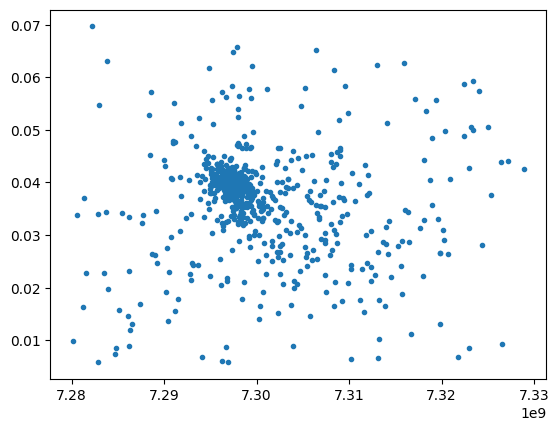

In [105]:
plt.plot(freq_q2,ampl_q2, "." )
plt.show()

In [6]:
# def process_fidelity_data(dataset, popsize, n_qubits):
#     """
#     Processes fidelity data for n qubits based on the given dataset and population size.

#     Parameters:
#         dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
#         popsize: The size of the population.
#         n_qubits: The number of qubits.

#     Returns:
#         A dictionary containing mean and population fidelity data for all qubits and shared parameters.
#     """
#     # Extract parameters shared across all qubits
#     shared_data = {
#         'freq': dataset.x0.data,
#         'ampl': dataset.x1.data,
#         'dur': dataset.x2.data,
#         'objective': dataset.y0.data,
#     }

#     # Initialize dictionary to hold data for each qubit
#     fidelity_data = {'shared': shared_data}

#     for q in range(1, n_qubits + 1):
#         # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
#         start_idx = 1 + (q - 1) * 6
#         # Extract fidelity data for the current qubit
#         fidelity_data[f'q{q}'] = {
#             'assfid_av': getattr(dataset, f'y{start_idx}').data,
#             'assfid_01': getattr(dataset, f'y{start_idx + 1}').data,
#             'assfid_02': getattr(dataset, f'y{start_idx + 2}').data,
#             'assfid_12': getattr(dataset, f'y{start_idx + 3}').data,
#             'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
#             'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
#         }

#         # Calculate mean fidelity values
#         fidelity_data[f'q{q}']['mean'] = {
#             key: fidelity_data[f'q{q}'][key][popsize::popsize + 1]
#             for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
#         }

#         # Mask for population fidelity values
#         mask = (np.arange(1, len(fidelity_data[f'q{q}']['assfid_av']) + 1) % int(popsize + 1) != 0)

#         # Calculate population fidelity values
#         fidelity_data[f'q{q}']['pop'] = {
#             key: fidelity_data[f'q{q}'][key][mask].reshape(popsize, -1)
#             for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
#         }

#     return fidelity_data


In [5]:
def process_fidelity_data(dataset, popsize, n_qubits):
    """
    Processes fidelity data for n qubits based on the given dataset and population size.

    Parameters:
        dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
        popsize: The size of the population.
        n_qubits: The number of qubits.

    Returns:
        A dictionary containing mean and population fidelity data for all qubits and shared parameters.
    """
    # Extract parameters shared across all qubits
    shared_data = {
        'freq': dataset.x0.data,
        'ampl': dataset.x1.data,
        'dur': dataset.x2.data,
        'objective': dataset.y0.data,
    }

    # Initialize dictionary to hold data for each qubit
    fidelity_data = {'shared': shared_data}

    for q in range(1, n_qubits + 1):
        # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
        start_idx = 1 + (q - 1) * 6
        # Extract fidelity data for the current qubit
        fidelity_data[f'q{q}'] = {
            'assfid_av': getattr(dataset, f'y{start_idx}').data,
            'assfid_01': getattr(dataset, f'y{start_idx + 1}').data,
            'assfid_02': getattr(dataset, f'y{start_idx + 2}').data,
            'assfid_12': getattr(dataset, f'y{start_idx + 3}').data,
            'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
            'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
        }

        # Calculate mean fidelity values
        fidelity_data[f'q{q}']['mean'] = {
            key: fidelity_data[f'q{q}'][key][popsize::popsize + 1]
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }

        # print(fidelity_data[f'q{q}']['assfid_av'][0::popsize+1])
        # Calculate population fidelity values using the new slicing logic
        fidelity_data[f'q{q}']['pop'] = {
            key: np.array([
                fidelity_data[f'q{q}'][key][i::popsize+1]
                for i in range(popsize)
            ])
            for key in ['assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }


    return fidelity_data

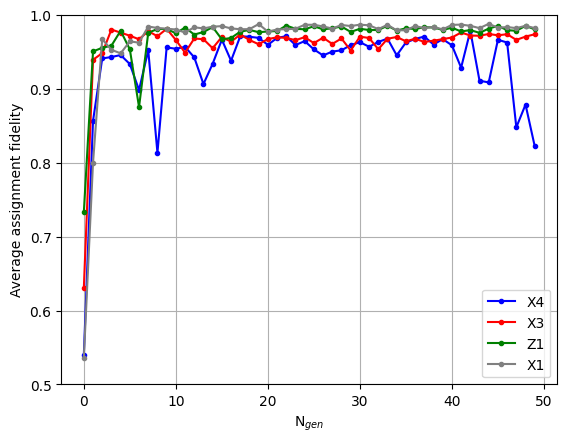

In [83]:
tuid = get_latest_tuid(contains="QNDPi4")
dataset2 = load_dataset(tuid)

Ngen = 50
n_qubits = 4
popsize = 16

fidelity_results2 = process_fidelity_data(dataset2, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results2['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results2['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results2['q2']['mean']['assfid_av']
qubit3_mean = fidelity_results2['q3']['mean']['assfid_av']
qubit4_mean = fidelity_results2['q4']['mean']['assfid_av']

plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")

plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()


In [90]:
set_datadir(default_datadir())
tuid = get_latest_tuid(contains="QNDPi_Readout10000reps")
dataset3 = load_dataset(tuid)
dataset3

Data will be saved in:
/home/pschaefers/quantify-data


<xarray.Dataset> Size: 435kB
Dimensions:  (dim_0: 850)
Coordinates: (12/21)
    x0       (dim_0) float64 7kB 7.365e+09 7.365e+09 ... 7.387e+09 7.394e+09
    x1       (dim_0) float64 7kB 0.005 0.01691 0.005 ... 0.02055 0.02423 0.02103
    x2       (dim_0) float64 7kB 4e-08 6.8e-08 4e-08 ... 5.48e-07 5.6e-07
    x3       (dim_0) float64 7kB 7.274e+09 7.273e+09 ... 7.3e+09 7.301e+09
    x4       (dim_0) float64 7kB 0.02111 0.005 0.03831 ... 0.03477 0.03599 0.033
    x5       (dim_0) float64 7kB 4e-08 4e-08 4e-08 ... 5.44e-07 5.8e-07 5.96e-07
    ...       ...
    x15      (dim_0) float64 7kB 7.478e+09 7.48e+09 ... 7.507e+09 7.509e+09
    x16      (dim_0) float64 7kB 0.005 0.02599 0.005 ... 0.04056 0.03151 0.04155
    x17      (dim_0) float64 7kB 4e-08 4e-08 3.6e-07 ... 6.44e-07 5.96e-07
    x18      (dim_0) float64 7kB 7.582e+09 7.574e+09 ... 7.608e+09 7.605e+09
    x19      (dim_0) float64 7kB 0.01552 0.005 0.005 ... 0.02278 0.02092 0.02317
    x20      (dim_0) float64 7kB 5e-07 2.52e-07 4.4e-07 ... 6.84e-07 6.4e-07
Dimensions without coordinates: dim_0
Data variables: (12/43)
    y0       (dim_0) float64 7kB -10.11 -9.896 -9.92 ... -43.65 -40.91 -42.12
    y1       (dim_0) float64 7kB 0.5085 0.5077 0.5108 ... 0.9588 0.9703 0.9596
    y2       (dim_0) float64 7kB 0.507 0.5046 0.5162 ... 0.9898 0.9904 0.99
    y3       (dim_0) float64 7kB 0.5124 0.5115 0.5108 ... 0.996 0.9903 0.9959
    y4       (dim_0) float64 7kB 0.5061 0.5071 0.5055 ... 0.8906 0.9301 0.8928
    y5       (dim_0) float64 7kB 0.5013 0.5075 0.5 0.5 ... 0.9723 0.9652 0.9658
    ...       ...
    y37      (dim_0) float64 7kB 0.5217 0.5121 0.5369 ... 0.9561 0.9581 0.9634
    y38      (dim_0) float64 7kB 0.513 0.5153 0.5173 ... 0.9688 0.9687 0.9622
    y39      (dim_0) float64 7kB 0.5303 0.5052 0.552 ... 0.9903 0.9904 0.9899
    y40      (dim_0) float64 7kB 0.5217 0.5158 0.5413 ... 0.9092 0.9152 0.938
    y41      (dim_0) float64 7kB 0.5 0.5044 0.5 0.5037 ... 0.9358 0.9376 0.9066
    y42      (dim_0) float64 7kB 0.5017 0.5 0.5077 ... 0.9279 0.9311 0.9101
Attributes:
    tuid:                             20250125-084659-398-cd1b49
    name:                             CMAES_QNDPi_Readout
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True
    elements:                         ['X4', 'X3', 'Z1', 'X1', 'Z3', 'Z4', 'Z2']
    edges:                            []

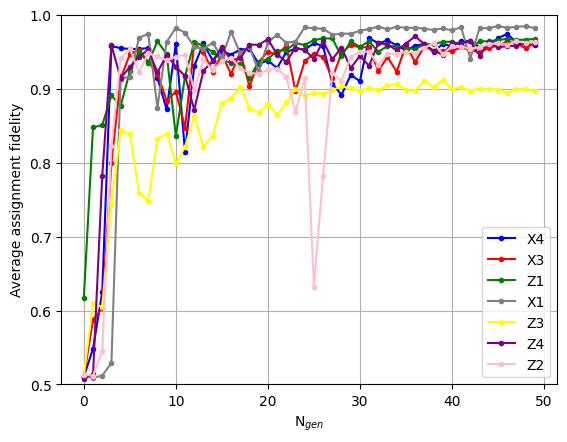

In [91]:
Ngen = 50
n_qubits = 7
popsize = 16

fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['assfid_av']
qubit3_mean = fidelity_results3['q3']['mean']['assfid_av']
qubit4_mean = fidelity_results3['q4']['mean']['assfid_av']
qubit5_mean = fidelity_results3['q5']['mean']['assfid_av']
qubit6_mean = fidelity_results3['q6']['mean']['assfid_av']
qubit7_mean = fidelity_results3['q7']['mean']['assfid_av']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

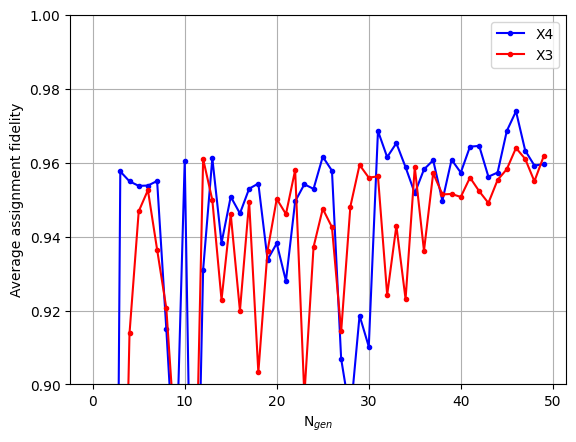

In [92]:
Ngen = 50
n_qubits = 7
popsize = 16

fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['assfid_av']
qubit3_mean = fidelity_results3['q3']['mean']['assfid_av']
qubit4_mean = fidelity_results3['q4']['mean']['assfid_av']
qubit5_mean = fidelity_results3['q5']['mean']['assfid_av']
qubit6_mean = fidelity_results3['q6']['mean']['assfid_av']
qubit7_mean = fidelity_results3['q7']['mean']['assfid_av']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
# plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
# plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
# plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
# plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
# plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.9,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

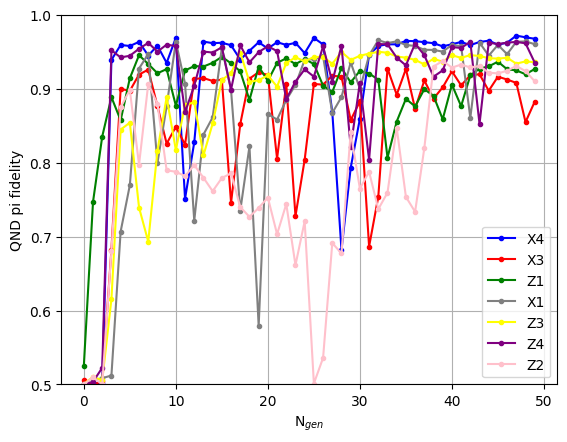

In [93]:
Ngen = 50
n_qubits = 7
popsize = 16

fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['qndpifid']
qubit3_mean = fidelity_results3['q3']['mean']['qndpifid']
qubit4_mean = fidelity_results3['q4']['mean']['qndpifid']
qubit5_mean = fidelity_results3['q5']['mean']['qndpifid']
qubit6_mean = fidelity_results3['q6']['mean']['qndpifid']
qubit7_mean = fidelity_results3['q7']['mean']['qndpifid']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.5,1)
plt.ylabel("QND pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

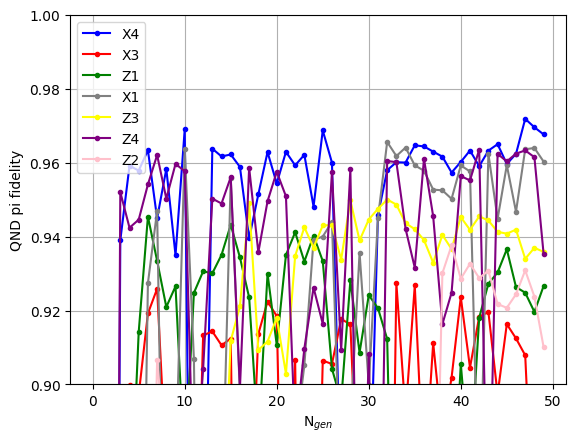

In [94]:
Ngen = 50
n_qubits = 7
popsize = 16

fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['qndpifid']
qubit3_mean = fidelity_results3['q3']['mean']['qndpifid']
qubit4_mean = fidelity_results3['q4']['mean']['qndpifid']
qubit5_mean = fidelity_results3['q5']['mean']['qndpifid']
qubit6_mean = fidelity_results3['q6']['mean']['qndpifid']
qubit7_mean = fidelity_results3['q7']['mean']['qndpifid']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.9,1)
plt.ylabel("QND pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

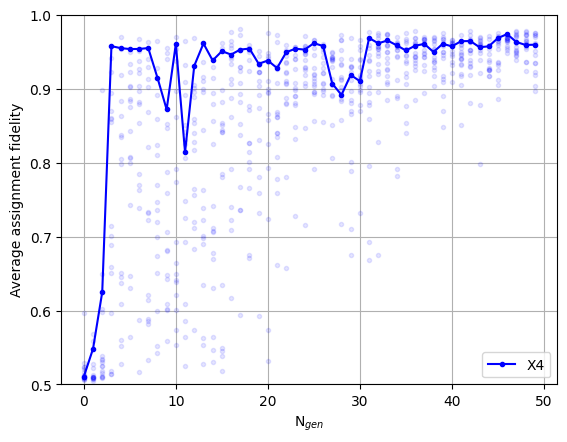

In [95]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit1_pop = fidelity_results3['q1']['pop']['assfid_av']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.1)


plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

In [118]:
Ngen = 50
n_qubits = 7
popsize = 100

set_datadir(default_datadir())
tuid = get_latest_tuid(contains="QNDPi_Readout_100pop")
dataset3 = load_dataset(tuid)

Data will be saved in:
/home/pschaefers/quantify-data


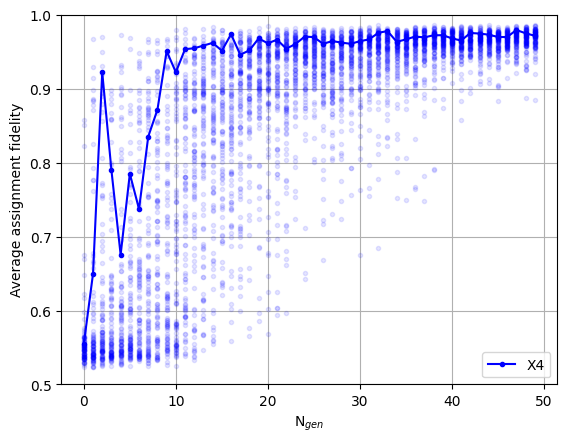

In [119]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit1_pop = fidelity_results3['q1']['pop']['assfid_av']

plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.1)


plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

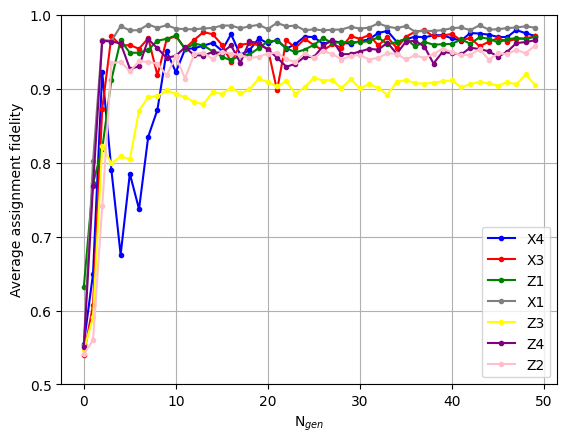

In [120]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['assfid_av']
qubit3_mean = fidelity_results3['q3']['mean']['assfid_av']
qubit4_mean = fidelity_results3['q4']['mean']['assfid_av']
qubit5_mean = fidelity_results3['q5']['mean']['assfid_av']
qubit6_mean = fidelity_results3['q6']['mean']['assfid_av']
qubit7_mean = fidelity_results3['q7']['mean']['assfid_av']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.5,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

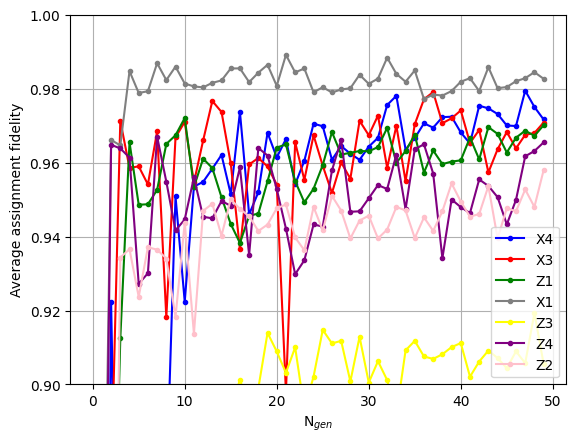

In [121]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['assfid_av']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['assfid_av']
qubit3_mean = fidelity_results3['q3']['mean']['assfid_av']
qubit4_mean = fidelity_results3['q4']['mean']['assfid_av']
qubit5_mean = fidelity_results3['q5']['mean']['assfid_av']
qubit6_mean = fidelity_results3['q6']['mean']['assfid_av']
qubit7_mean = fidelity_results3['q7']['mean']['assfid_av']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.9,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

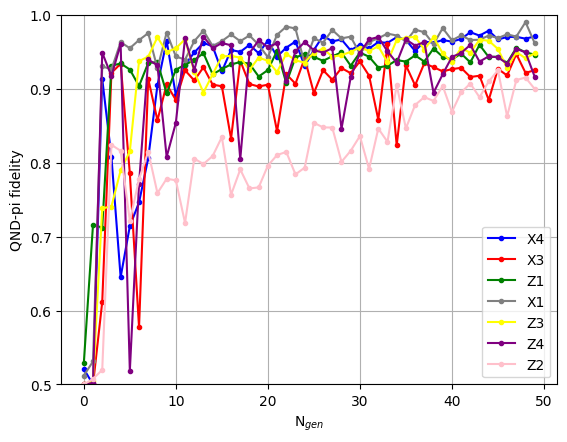

In [122]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['qndpifid']
qubit3_mean = fidelity_results3['q3']['mean']['qndpifid']
qubit4_mean = fidelity_results3['q4']['mean']['qndpifid']
qubit5_mean = fidelity_results3['q5']['mean']['qndpifid']
qubit6_mean = fidelity_results3['q6']['mean']['qndpifid']
qubit7_mean = fidelity_results3['q7']['mean']['qndpifid']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.5,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

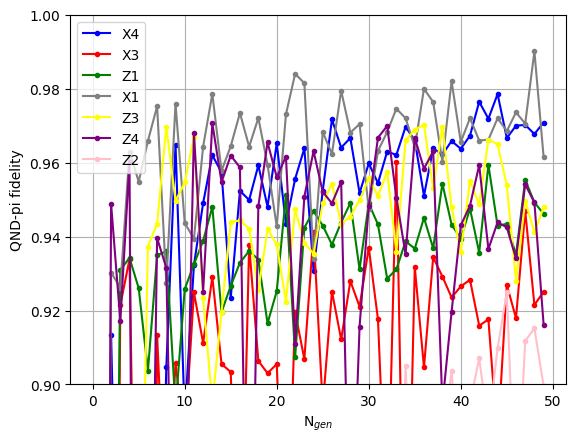

In [123]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit2_mean = fidelity_results3['q2']['mean']['qndpifid']
qubit3_mean = fidelity_results3['q3']['mean']['qndpifid']
qubit4_mean = fidelity_results3['q4']['mean']['qndpifid']
qubit5_mean = fidelity_results3['q5']['mean']['qndpifid']
qubit6_mean = fidelity_results3['q6']['mean']['qndpifid']
qubit7_mean = fidelity_results3['q7']['mean']['qndpifid']


plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X3")
plt.plot(range(Ngen),qubit3_mean,'-o',c="green",ms=3, label = "Z1")
plt.plot(range(Ngen),qubit4_mean,'-o',c="grey",ms=3, label = "X1")
plt.plot(range(Ngen),qubit5_mean,'-o',c="yellow",ms=3, label = "Z3")
plt.plot(range(Ngen),qubit6_mean,'-o',c="purple",ms=3, label = "Z4")
plt.plot(range(Ngen),qubit7_mean,'-o',c="pink",ms=3, label = "Z2")

plt.ylim(0.9,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

In [136]:
Ngen = 40
n_qubits = 2
popsize = 16

set_datadir(default_datadir())
tuid = get_latest_tuid(contains="CMAES_2qb")
dataset3 = load_dataset(tuid)

Data will be saved in:
/home/pschaefers/quantify-data


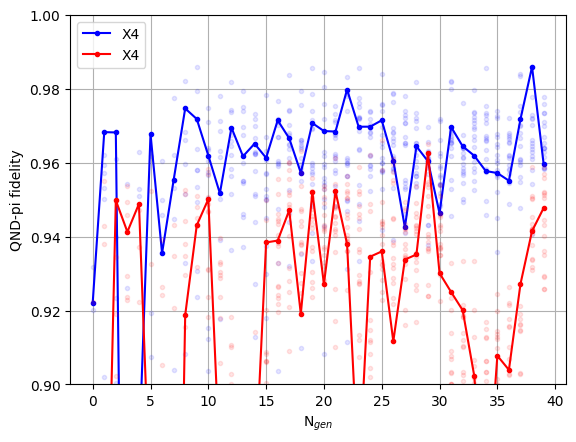

In [153]:
fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)
# Access shared data
shared_params = fidelity_results3['shared']

# Access results for a specific qubit
qubit1_mean = fidelity_results3['q1']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit1_pop = fidelity_results3['q1']['pop']['qndpifid']

# Access results for a specific qubit
qubit2_mean = fidelity_results3['q2']['mean']['qndpifid']  # Mean fidelity values for qubit 1
qubit2_pop = fidelity_results3['q2']['pop']['qndpifid']

plt.plot(range(Ngen),qubit1_mean,'-o',c="blue",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop[i],".",c="blue",alpha=.1)


plt.plot(range(Ngen),qubit2_mean,'-o',c="red",ms=3, label = "X4")
for i in range(popsize):
    plt.plot(range(Ngen),qubit2_pop[i],".",c="red",alpha=.1)


plt.ylim(0.9,1)
plt.ylabel("QND-pi fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

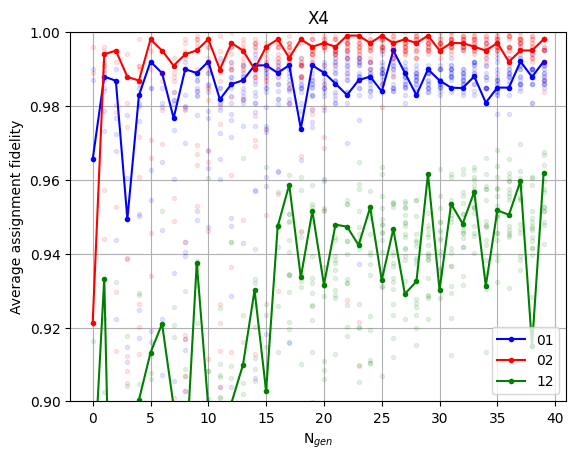

In [150]:
# Access results for a specific qubit
qubit1_mean_01 = fidelity_results3['q1']['mean']['assfid_01'] 
qubit1_pop_01 = fidelity_results3['q1']['pop']['assfid_01']

qubit1_mean_02 = fidelity_results3['q1']['mean']['assfid_02'] 
qubit1_pop_02 = fidelity_results3['q1']['pop']['assfid_02']

qubit1_mean_12 = fidelity_results3['q1']['mean']['assfid_12'] 
qubit1_pop_12 = fidelity_results3['q1']['pop']['assfid_12']


plt.plot(range(Ngen),qubit1_mean_01,'-o',c="blue",ms=3, label = "01")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop_01[i],".",c="blue",alpha=.1)

plt.plot(range(Ngen),qubit1_mean_02,'-o',c="red",ms=3, label = "02")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop_02[i],".",c="red",alpha=.1)

plt.plot(range(Ngen),qubit1_mean_12,'-o',c="green",ms=3, label = "12")
for i in range(popsize):
    plt.plot(range(Ngen),qubit1_pop_12[i],".",c="green",alpha=.1)

plt.title("X4")
plt.ylim(0.9,1)
plt.ylabel("Average assignment fidelity")
plt.xlabel(r"N$_{gen}$")
plt.grid()
plt.legend()
plt.show()

In [5]:
Ngen = 50
n_qubits = 7
popsize = 50

set_datadir(default_datadir())
tuid = get_latest_tuid(contains="QNDPi_Readout_500ns")
dataset3 = load_dataset(tuid)

fidelity_results3 = process_fidelity_data(dataset3, popsize, n_qubits)

Data will be saved in:
/home/pschaefers/quantify-data


In [14]:
qubit_max = np.max(fidelity_results3['q7']['mean']['assfid_av'][-30:])
qubit_max_qnd = np.max(fidelity_results3['q7']['mean']['qndpifid'][-30:])
print(qubit_max)
print(qubit_max_qnd)

0.8973151328271393
0.8222590552332667
